<a href="https://colab.research.google.com/github/AndresRestrepoRodriguez/computer_vision/blob/main/Image_Classifier_CNN_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

In [2]:
dataset = {
    'train': torchvision.datasets.MNIST('./data', train=True, download=True, transform=torchvision.transforms.ToTensor()),
    'test': torchvision.datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.ToTensor())
}

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
len(dataset['train']), len(dataset['test'])

(60000, 10000)

In [4]:
type(dataset['train'][0][0])

torch.Tensor

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random 

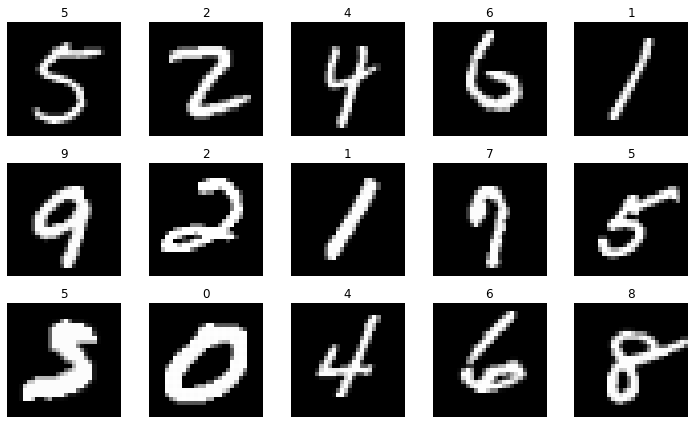

In [6]:
rows, cols = 3, 5
fig = plt.figure(figsize=(2*cols, 2*rows))
for row in range(rows):
    for col in range(cols):
        plt.subplot(rows, cols, row*cols + col + 1)
        ix = random.randint(0, len(dataset['train'])-1)
        img, label = dataset['train'][ix]
        plt.imshow(img.squeeze(0), cmap='gray')
        plt.axis("off")
        plt.title(label)
plt.tight_layout()
plt.show()

In [7]:
img.shape, img.dtype, img.max(), img.min()

(torch.Size([1, 28, 28]), torch.float32, tensor(1.), tensor(0.))

In [8]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def block2(c_in, c_out):
    return torch.nn.Sequential(
        torch.nn.Linear(c_in, c_out),
        torch.nn.ReLU()
    )

class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv2 = block(64, 128)
    self.fc = torch.nn.Linear(128*7*7, n_outputs)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

In [29]:
model = CNN()
output = model(torch.randn(64, 1, 28, 28))
output.shape

torch.Size([64, 10])

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"

from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5):
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = torch.nn.CrossEntropyLoss()
  for epoch in range(1, epochs+1):
    model.train()
    train_loss, train_acc = [], []
    bar = tqdm(dataloader['train'])
    for batch in bar:
      X, y = batch
      X, y = X.to(device), y.to(device)
      optimizer.zero_grad()
      y_hat = model(X)
      loss = criterion(y_hat, y)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
      acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
      train_acc.append(acc)
      bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
    bar = tqdm(dataloader['test'])
    val_loss, val_acc = [], []
    model.eval()
    with torch.no_grad():
      for batch in bar:
        X, y = batch
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = criterion(y_hat, y)
        val_loss.append(loss.item())
        acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
        val_acc.append(acc)
        bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
      print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")





In [22]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=64, shuffle=False, pin_memory=True)
}

In [40]:
model = CNN()
fit(model, dataloader)

val_loss 0.05725 val_acc 0.98159: 100%|██████████| 157/157 [00:01<00:00, 91.98it/s]


Epoch 1/5 loss 0.14394 val_loss 0.05725 acc 0.95652 val_acc 0.98159


val_loss 0.03860 val_acc 0.98706: 100%|██████████| 157/157 [00:01<00:00, 90.38it/s]


Epoch 2/5 loss 0.04507 val_loss 0.03860 acc 0.98601 val_acc 0.98706


val_loss 0.03123 val_acc 0.99035: 100%|██████████| 157/157 [00:01<00:00, 90.52it/s]


Epoch 3/5 loss 0.03196 val_loss 0.03123 acc 0.98971 val_acc 0.99035


val_loss 0.03076 val_acc 0.99074: 100%|██████████| 157/157 [00:01<00:00, 94.02it/s]


Epoch 4/5 loss 0.02471 val_loss 0.03076 acc 0.99210 val_acc 0.99074


val_loss 0.03371 val_acc 0.98955: 100%|██████████| 157/157 [00:01<00:00, 95.41it/s]

Epoch 5/5 loss 0.01791 val_loss 0.03371 acc 0.99434 val_acc 0.98955


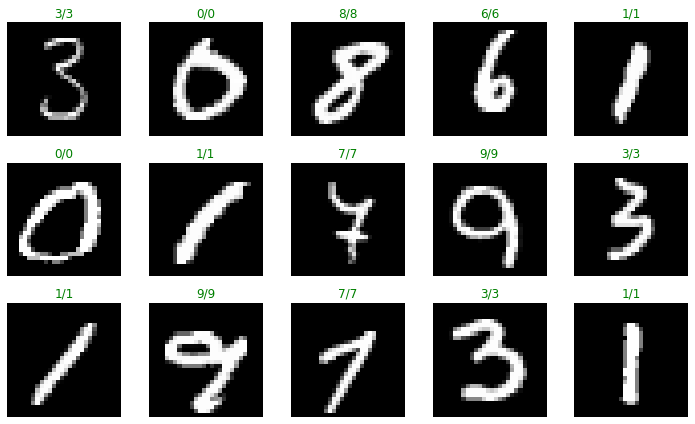

In [38]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset['test'])-1)
        img, label = dataset['test'][ix]
        preds = model(img.unsqueeze(0).to(device))
        pred = torch.argmax(preds, axis=1)[0].item()
        plt.imshow(img.squeeze(0), cmap='gray')
        plt.axis("off")
        plt.title(f'{label}/{pred}', color = "red" if label != pred else "green")
plt.tight_layout()
plt.show()